In [7]:
import sklearn
import numpy as np
import os

np.random.seed(42)

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)
plt.style.use('seaborn')

Support vector machines are versatile ML models that can be used for linear or non-linear classification, regression and even outlier detection.

They are particularly well-suited to complex small/medium sized datasets

# Linear SVM Classification

We'll start our discussion by looking at some images. They will help us explain the fundamental idea behind SVMs.

As in the previous chapter we'll use the iris dataset. Consider the plot below which shows decision boundaries of three possible linear classifiers.

*snippet taken from github.com/ageron/handson-ml2 *

In [8]:
from sklearn.svm import SVC
from sklearn import datasets

iris = datasets.load_iris()
X = iris['data'][:, (2,3)] # petal length, petal width
y = iris['target']

setosa_or_versicolor = (y == 0) | (y == 1)
X = X[setosa_or_versicolor]
y = y[setosa_or_versicolor]

svm_clf = SVC(kernel='linear', C=float('inf'))
svm_clf.fit(X,y)

# Bad models
x0 = np.linspace(0, 5.5, 200)
pred_1 = 5*x0 - 20
pred_2 = x0 - 1.8
pred_3 = 0.1 * x0 + 0.5

def plot_svc_decision_boundary(svm_clf, xmin, xmax):
    w = svm_clf.coef_[0]
    b = svm_clf.intercept_[0]

    # At the decision boundary, w0*x0 + w1*x1 + b = 0
    # => x1 = -w0/w1 * x0 - b/w1
    x0 = np.linspace(xmin, xmax, 200)
    decision_boundary = -w[0]/w[1] * x0 - b/w[1]

    margin = 1/w[1]
    gutter_up = decision_boundary + margin
    gutter_down = decision_boundary - margin

    svs = svm_clf.support_vectors_
    plt.scatter(svs[:, 0], svs[:, 1], s=180, facecolors='#FFAAAA')
    plt.plot(x0, decision_boundary, "k-", linewidth=2)
    plt.plot(x0, gutter_up, "k--", linewidth=2)
    plt.plot(x0, gutter_down, "k--", linewidth=2)

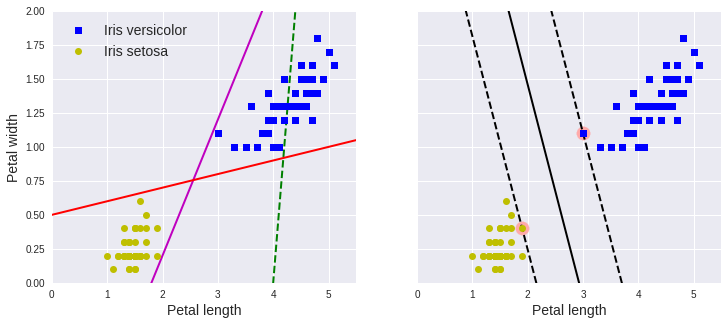

In [10]:
fig, axes = plt.subplots(ncols=2, figsize=(12,5), sharey=True)

plt.sca(axes[0]) # set current axes
plt.plot(x0, pred_1, "g--", linewidth=2)
plt.plot(x0, pred_2, "m-", linewidth=2)
plt.plot(x0, pred_3, "r-", linewidth=2)
plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bs", label="Iris versicolor")
plt.plot(X[:, 0][y==0], X[:, 1][y==0], "yo", label="Iris setosa")
plt.xlabel("Petal length", fontsize=14)
plt.ylabel("Petal width", fontsize=14)
plt.legend(loc="upper left", fontsize=14)
plt.axis([0, 5.5, 0, 2])

plt.sca(axes[1])
plot_svc_decision_boundary(svm_clf, 0, 5.5)
plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bs")
plt.plot(X[:, 0][y==0], X[:, 1][y==0], "yo")
plt.xlabel("Petal length", fontsize=14)
plt.axis([0, 5.5, 0, 2])

plt.show()

From the positioning of the dots and squares, it is easy to see that these two classes are linearly separable.

On the left, the green dashed line does a poor job of separating the classed. In contrast both the magenta and red line do a good job of classifying the training set, but the boundary is so close to the training instances that it might perform poorly on new instances.

The model on the right (an SVM) finds a line that not only separates the two classes, but also tries to stay away as far as possible from the instances. By fitting the widest margin possible, we're doing *large margin classification*.

The margins are fully defind by the training instances lying on the boundaries. These are called **support vectors**. (circled in pink in the image above)

**NOTE:** SVMs are very sensitive to feature scales! Always scale your data before fitting a SVM. (example on pg. 154)

### Hard vs Soft Margin

Because there's an area between decision boundaries, we can specify how the model approaches constructing the boundaries. If we impose that all instances must be outside the boundaries and on the correct classes we are imposing *hard margin classification*.

While it specifies a stricter model, this approach has two main problems:
- Only works if the data is linearly separable
- Sensitive to outliers

Take the two plots below as an example

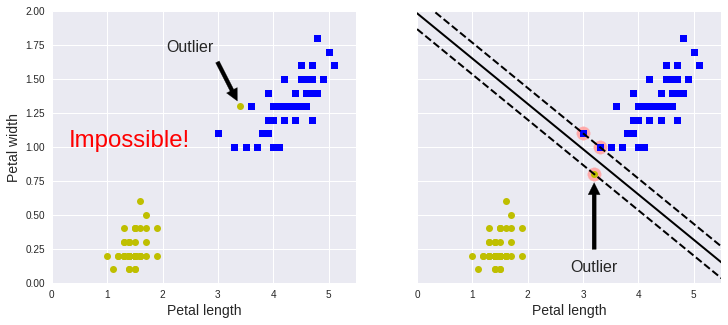

In [11]:
X_outliers = np.array([[3.4, 1.3], [3.2, 0.8]])
y_outliers = np.array([0, 0])
Xo1 = np.concatenate([X, X_outliers[:1]], axis=0)
yo1 = np.concatenate([y, y_outliers[:1]], axis=0)
Xo2 = np.concatenate([X, X_outliers[1:]], axis=0)
yo2 = np.concatenate([y, y_outliers[1:]], axis=0)

svm_clf2 = SVC(kernel="linear", C=10**9)
svm_clf2.fit(Xo2, yo2)

fig, axes = plt.subplots(ncols=2, figsize=(12,5), sharey=True)

plt.sca(axes[0])
plt.plot(Xo1[:, 0][yo1==1], Xo1[:, 1][yo1==1], "bs")
plt.plot(Xo1[:, 0][yo1==0], Xo1[:, 1][yo1==0], "yo")
plt.text(0.3, 1.0, "Impossible!", fontsize=24, color="red")
plt.xlabel("Petal length", fontsize=14)
plt.ylabel("Petal width", fontsize=14)
plt.annotate("Outlier",
             xy=(X_outliers[0][0], X_outliers[0][1]),
             xytext=(2.5, 1.7),
             ha="center",
             arrowprops=dict(facecolor='black', shrink=0.1),
             fontsize=16,
            )
plt.axis([0, 5.5, 0, 2])

plt.sca(axes[1])
plt.plot(Xo2[:, 0][yo2==1], Xo2[:, 1][yo2==1], "bs")
plt.plot(Xo2[:, 0][yo2==0], Xo2[:, 1][yo2==0], "yo")
plot_svc_decision_boundary(svm_clf2, 0, 5.5)
plt.xlabel("Petal length", fontsize=14)
plt.annotate("Outlier",
             xy=(X_outliers[1][0], X_outliers[1][1]),
             xytext=(3.2, 0.08),
             ha="center",
             arrowprops=dict(facecolor='black', shrink=0.1),
             fontsize=16,
            )
plt.axis([0, 5.5, 0, 2])

plt.show()

On the left, it is impossible to find a hard margin. On the right the decision boundaries are very different from the one above and probably won't generalize well.

To overcome these, we can take a more flexible approach and allow for *margin violations* (i.e. instances that are on the wrong side or between the boundaries). 

Margin violations are bad, thus we try to minimize them. With a **soft margin classifier** we try to find a balance between having a large distance between the boundaries while minimizing the number of margin violations.

In sklearn, the hyperparameter C is in control of regularization. If the SVM is overfitting,  we can try reducing the value of C. *(see page 155 for plot with different values of C)*

Here's our first example to detect iris virginica flowers

In [12]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC

X = iris['data'][:, (2,3)] # reload petal length, petal width
y = (iris['target'] == 2).astype(np.float64) # iris virginica

svm_clf = Pipeline([
    ('scale', StandardScaler()),
    ('linear_svc', LinearSVC(C=1, loss='hinge'))
])
svm_clf.fit(X, y)

Pipeline(memory=None,
         steps=[('scale',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('linear_svc',
                 LinearSVC(C=1, class_weight=None, dual=True,
                           fit_intercept=True, intercept_scaling=1,
                           loss='hinge', max_iter=1000, multi_class='ovr',
                           penalty='l2', random_state=None, tol=0.0001,
                           verbose=0))],
         verbose=False)

In [13]:
svm_clf.predict([[5.5, 1.7]])

array([1.])

*Notes*

Instead of LinearSVC we could've used SVC(kernel='linear', C=1) or SGDClassifier(loss='hinge', alpha=1/(m\*C)). The latter uses SGD and while slower to converge, it can be used for online training and out-of-core training.

- SVMs do not output class probabilities, but an actual class.
- *LinearSVC* regularizes the bias term, so the data should be centered (by subtracting the mean, for example using StandardScaler). 
- Set the loss hyperparameter to hinge as it is not the default
- For better performance, set dual=False, unless there are more features than training instances

# Non-linear SVM Classification

While linear SVM classifiers are efficient, it is often the case that our data is not linearly separable. One approach to handling these datasets, is to add more features. (see fig 5-5 pg 157).

We'll implement this idea by using the moons dataset by implementing a pipeline using a PolynomialFeatures transformer, followed by a scaler and a linearSVC. The moons dataset is a toy dataset where the data is shaped as two interleaving half circles.

In [14]:
def plot_dataset(X, y, axes):
    plt.plot(X[y==0][:, 0], X[y==0][:, 1], 'bo')
    plt.plot(X[y==1][:, 0], X[y==1][:, 1], 'go')
    plt.axis(axes)
    plt.xlabel(r"$x_1$", fontsize=20)
    plt.ylabel(r"$x_2$", fontsize=20, rotation=0)

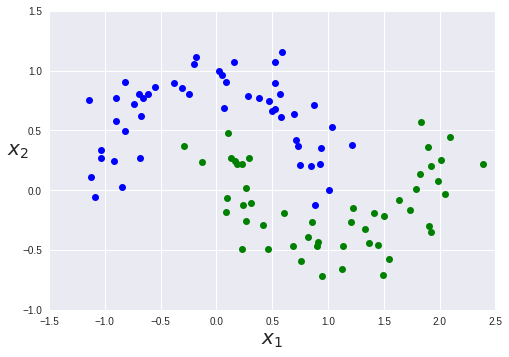

In [15]:
from sklearn.datasets import make_moons
from sklearn.preprocessing import PolynomialFeatures

X, y = make_moons(n_samples=100, noise=0.15 )
axes = [-1.5, 2.5, -1, 1.5]
plot_dataset(X,y, axes)
plt.show()

In [16]:
polynomial_svm_clf = Pipeline([
    ('poly_features', PolynomialFeatures(degree=3)),
    ('scale', StandardScaler()),
    ('linear_svm', LinearSVC(C=10, loss='hinge'))
])
polynomial_svm_clf.fit(X, y)

/home/carlos/.local/lib/python3.6/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Pipeline(memory=None,
         steps=[('poly_features',
                 PolynomialFeatures(degree=3, include_bias=True,
                                    interaction_only=False, order='C')),
                ('scale',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('linear_svm',
                 LinearSVC(C=10, class_weight=None, dual=True,
                           fit_intercept=True, intercept_scaling=1,
                           loss='hinge', max_iter=1000, multi_class='ovr',
                           penalty='l2', random_state=None, tol=0.0001,
                           verbose=0))],
         verbose=False)

In [17]:
def plot_predictions(clf, axes):
    x0s = np.linspace(axes[0], axes[1], 300)
    x1s = np.linspace(axes[0], axes[3], 300)
    x0, x1 = np.meshgrid(x0s, x1s)
    X = np.c_[x0.ravel(), x1.ravel()]
    y_pred = clf.predict(X).reshape(x0.shape)
    y_decision = clf.decision_function(X).reshape(x0.shape)
    plt.contourf(x0, x1, y_pred, cmap=plt.cm.brg, alpha=0.2)
    plt.contourf(x0, x1, y_decision, cmap=plt.cm.brg, alpha=0.1)

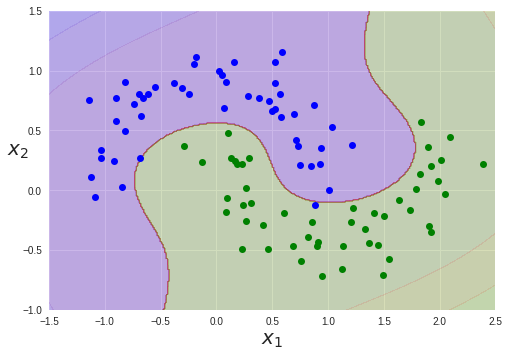

In [18]:
plot_predictions(polynomial_svm_clf, axes)
plot_dataset(X, y, axes)
plt.show()

## Polynomial Kernel

Polynomial features are useful and can be used for various models. However at a low degree it won't handle complex datasets, and at very high degrees, it adds lots of features making the model too slow.

SVMs allow us to use a kernel trick (see below), which yields the same result as if we used many polynomial features but without actually having to add them.

Below we train two models, one with degree 3 and other with degree 10 and plot their results. The parameter coef0 controls how much the model is influenced by high-degree polynomial vs low-degree polynomials.

In [19]:
# Polynomial kernel of degree 3
poly3_kernel_svm_clf = Pipeline([
    ('scale', StandardScaler()),
    ('svm_clf', SVC(kernel='poly', degree=3, coef0=1, C=5))
])
poly3_kernel_svm_clf.fit(X, y)

# Polynomial kernel of degree 10
poly10_kernel_svm_clf = Pipeline([
    ('scale', StandardScaler()),
    ('svm_clf', SVC(kernel='poly', degree=10, coef0=100, C=5))
])
poly10_kernel_svm_clf.fit(X, y)

Pipeline(memory=None,
         steps=[('scale',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('svm_clf',
                 SVC(C=5, break_ties=False, cache_size=200, class_weight=None,
                     coef0=100, decision_function_shape='ovr', degree=10,
                     gamma='scale', kernel='poly', max_iter=-1,
                     probability=False, random_state=None, shrinking=True,
                     tol=0.001, verbose=False))],
         verbose=False)

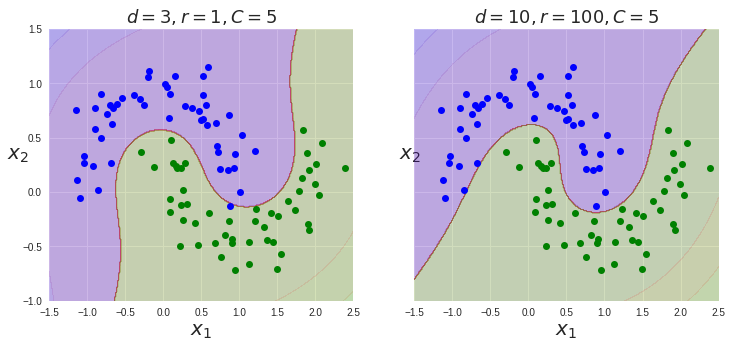

In [20]:
fig, ax = plt.subplots(figsize=(12, 5), ncols=2, sharey=True)

plt.sca(ax[0])
plot_predictions(poly3_kernel_svm_clf, axes)
plot_dataset(X, y, axes)
plt.title(r'$d = 3, r = 1, C = 5$', fontsize=18)

plt.sca(ax[1])
plot_predictions(poly10_kernel_svm_clf, axes)
plot_dataset(X, y, axes)
plt.title('$d = 10, r = 100, C = 5$', fontsize=18)

plt.show()

GridSearch is perfect for optimizing hyperparameters!

### Similarity Features

Another way to approach non-linear problems, is to add features computing a *similarity function*, which measures how much each instance resembles a given landmark.

One similarity function we can use is the *Gaussian Radial Basis* function
$$ \phi_\gamma(\textbf{x}, l) = \exp{(-\gamma||\textbf{x} - l||^2)}$$

**Note on Radial Basis functions**

A radial basis function is a real-valued function $\phi$ whose value depends only on the distance between the input and some fixed location $\textbf{c}$. Tipically the fixed location is picked as the origin and $||\textbf{x}||$ is the euclidean norm

$$ \phi(\textbf{x, c}) = \phi(||\textbf{x - c}||) $$

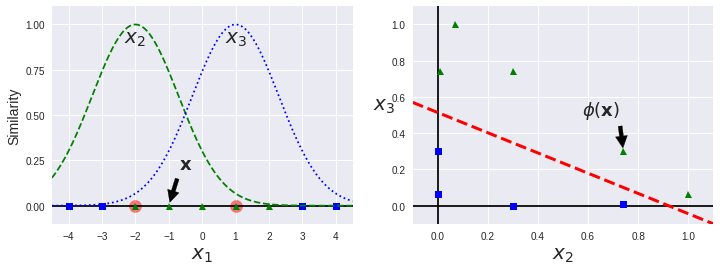

In [21]:
def gaussian_rbf(x, landmark, gamma):
    return np.exp(-gamma * np.linalg.norm(x - landmark, axis=1)**2)

gamma = 0.3

x1s = np.linspace(-4.5, 4.5, 200).reshape(-1, 1)
x2s = gaussian_rbf(x1s, -2, gamma)
x3s = gaussian_rbf(x1s, 1, gamma)

X1D = np.linspace(-4, 4, 9).reshape(-1, 1)
X2D = np.c_[X1D, X1D**2]
XK = np.c_[gaussian_rbf(X1D, -2, gamma), gaussian_rbf(X1D, 1, gamma)]
yk = np.array([0, 0, 1, 1, 1, 1, 1, 0, 0])

plt.figure(figsize=(10.5, 4))

plt.subplot(121)
plt.grid(True, which='both')
plt.axhline(y=0, color='k')
plt.scatter(x=[-2, 1], y=[0, 0], s=150, alpha=0.5, c="red")
plt.plot(X1D[:, 0][yk==0], np.zeros(4), "bs")
plt.plot(X1D[:, 0][yk==1], np.zeros(5), "g^")
plt.plot(x1s, x2s, "g--")
plt.plot(x1s, x3s, "b:")
plt.gca().get_yaxis().set_ticks([0, 0.25, 0.5, 0.75, 1])
plt.xlabel(r"$x_1$", fontsize=20)
plt.ylabel(r"Similarity", fontsize=14)
plt.annotate(r'$\mathbf{x}$',
             xy=(X1D[3, 0], 0),
             xytext=(-0.5, 0.20),
             ha="center",
             arrowprops=dict(facecolor='black', shrink=0.1),
             fontsize=18,
            )
plt.text(-2, 0.9, "$x_2$", ha="center", fontsize=20)
plt.text(1, 0.9, "$x_3$", ha="center", fontsize=20)
plt.axis([-4.5, 4.5, -0.1, 1.1])

plt.subplot(122)
plt.grid(True, which='both')
plt.axhline(y=0, color='k')
plt.axvline(x=0, color='k')
plt.plot(XK[:, 0][yk==0], XK[:, 1][yk==0], "bs")
plt.plot(XK[:, 0][yk==1], XK[:, 1][yk==1], "g^")
plt.xlabel(r"$x_2$", fontsize=20)
plt.ylabel(r"$x_3$  ", fontsize=20, rotation=0)
plt.annotate(r'$\phi\left(\mathbf{x}\right)$',
             xy=(XK[3, 0], XK[3, 1]),
             xytext=(0.65, 0.50),
             ha="center",
             arrowprops=dict(facecolor='black', shrink=0.1),
             fontsize=18,
            )
plt.plot([-0.1, 1.1], [0.57, -0.1], "r--", linewidth=3)
plt.axis([-0.1, 1.1, -0.1, 1.1])
    
plt.subplots_adjust(right=1)

plt.show()

The dataset on the left plot above is non-linearly separable. But by applying a gaussian RBF, we it becomes linearly separable. 

One apporach to choosing landmarks is to create one at each instance of the dataset. This will increase the dataset dimensionality and thus increasing the chance that it is linearly separable. However, a training set with $m$ instances and $n$ features will be transformed and have $m$ instances and $m$ features. For large datasets, the number of training features will explode.

Just like the polynomial kernel, similarity features can be used for any ML algorithm, but it can become computationally expensive to compute the additional features. Again, because of the Kernel trick, SVMs can add these extra features efficiently.

In [22]:
rbf_kernel_svm_clf = Pipeline([
    ('scaler', StandardScaler()),
    ('svm_clf', SVC(kernel='rbf', gamma=5, C=0.001))
])
rbf_kernel_svm_clf.fit(X, y)

Pipeline(memory=None,
         steps=[('scaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('svm_clf',
                 SVC(C=0.001, break_ties=False, cache_size=200,
                     class_weight=None, coef0=0.0,
                     decision_function_shape='ovr', degree=3, gamma=5,
                     kernel='rbf', max_iter=-1, probability=False,
                     random_state=None, shrinking=True, tol=0.001,
                     verbose=False))],
         verbose=False)

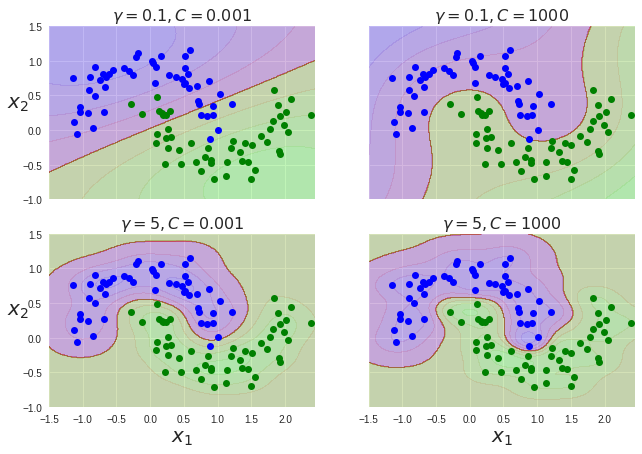

In [23]:
gamma1, gamma2 = 0.1, 5
C1, C2 = 0.001, 1000
hyperparams = (gamma1, C1), (gamma1, C2), (gamma2, C1), (gamma2, C2)

svm_clfs = []
for gamma, C in hyperparams:
    rbf_kernel_svm_clf = Pipeline([
            ("scaler", StandardScaler()),
            ("svm_clf", SVC(kernel="rbf", gamma=gamma, C=C))
        ])
    rbf_kernel_svm_clf.fit(X, y)
    svm_clfs.append(rbf_kernel_svm_clf)

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10.5, 7), sharex=True, sharey=True)
for i, svm_clf in enumerate(svm_clfs):
    plt.sca(axes[i // 2, i % 2])
    plot_predictions(svm_clf, [-1.5, 2.45, -1, 1.5])
    plot_dataset(X, y, [-1.5, 2.45, -1, 1.5])
    gamma, C = hyperparams[i]
    plt.title(r"$\gamma = {}, C = {}$".format(gamma, C), fontsize=16)
    if i in (0, 1):
        plt.xlabel("")
    if i in (1, 3):
        plt.ylabel("")
        
plt.show()

Increasing gamma makes the bell cuve narrower (decreases skewness). As a result, each instance's range of influence is smaller: the decision boundary ends up being more irregular, wiggling around individual instances,

Conversely, small gamma makes the bell shaped curve wider (increases skewness). Instances have a larger range of influence and the decision boundares is smoother.

So $\gamma$ acts like a regularization parameter. If the model is overfitting, reduce it. If it is underfitting, increase it.

Other kernels exist but are used more rarely. String kernels are used for classifying text documents or DNA sequences (e.g. string subsequence kernel or kernels based on levenshtein distance)

As a rule of thumb, start with a linear kernel (remember that LinearSVM is faster than SVC(kernel='linear'). If the training set is not too large, try the Gaussian RBF.

If there's extra time, try using other kernels with GridSearch and crossvalidation. This can be worthwhile especially if there are kernels specialized for your training set data structure.

### Computational Complexity

LinearSVC is based on the liblinear library which implements and optimized algorithm. While it does not support the kernel trick, its complexity is $O(m\times n)$.
This can take much longer if you require high precision (controlled by hyperparameter $\epsilon$, called *tol* in sklearn). For most cases, default tolerance is fine.

SVC class is based on lobsvm library, and its algorithm supports the kernel trick. Training complexity is between $O(m^2 \times n)$ and $O(m^3 \times n)$, which means it gets extremely slow with large training sets. Better used for small/medium sized training sets and it scales well with the number of features, especially if they are sparse.

## SVM Regression

We can also use SVMs to perform linear and non-linear regression. For regression, instead of trying to maximise the width of the decision boundaries and limiting margin violations, the SVM tries to fit as many instances as possible *on* the street while limiting margin violations.

The width of the boundaries is controlled by a parameter $\epsilon$. Adding more training instances within the boundaries does not affect the model's prediction. We say the model is $\epsilon$-insensitive.

The plot below shows two Linear SVM Regressors with different values or $\epsilon$

In [24]:
np.random.seed(42)
m = 50
X = 2 * np.random.rand(m, 1)
y = (4 + 3 * X + np.random.randn(m, 1)).ravel()

In [25]:
from sklearn.svm import LinearSVR

svm_reg1 = LinearSVR(epsilon=1.5, random_state=42)
svm_reg2 = LinearSVR(epsilon=0.5, random_state=42)
svm_reg1.fit(X, y)
svm_reg2.fit(X, y)

def find_support_vectors(svm_reg, X, y):
    y_pred = svm_reg.predict(X)
    off_margin = (np.abs(y - y_pred) >= svm_reg.epsilon)
    return np.argwhere(off_margin)

svm_reg1.support_ = find_support_vectors(svm_reg1, X, y)
svm_reg2.support_ = find_support_vectors(svm_reg2, X, y)

eps_x1 = 1
eps_y_pred = svm_reg1.predict([[eps_x1]])

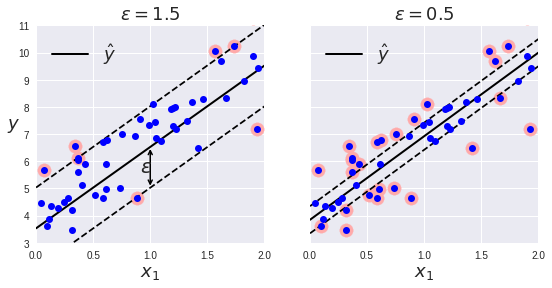

In [26]:
def plot_svm_regression(svm_reg, X, y, axes):
    x1s = np.linspace(axes[0], axes[1], 100).reshape(100, 1)
    y_pred = svm_reg.predict(x1s)
    plt.plot(x1s, y_pred, "k-", linewidth=2, label=r"$\hat{y}$")
    plt.plot(x1s, y_pred + svm_reg.epsilon, "k--")
    plt.plot(x1s, y_pred - svm_reg.epsilon, "k--")
    plt.scatter(X[svm_reg.support_], y[svm_reg.support_], s=180, facecolors='#FFAAAA')
    plt.plot(X, y, "bo")
    plt.xlabel(r"$x_1$", fontsize=18)
    plt.legend(loc="upper left", fontsize=18)
    plt.axis(axes)

fig, axes = plt.subplots(ncols=2, figsize=(9, 4), sharey=True)
plt.sca(axes[0])
plot_svm_regression(svm_reg1, X, y, [0, 2, 3, 11])
plt.title(r"$\epsilon = {}$".format(svm_reg1.epsilon), fontsize=18)
plt.ylabel(r"$y$", fontsize=18, rotation=0)
#plt.plot([eps_x1, eps_x1], [eps_y_pred, eps_y_pred - svm_reg1.epsilon], "k-", linewidth=2)
plt.annotate(
        '', xy=(eps_x1, eps_y_pred), xycoords='data',
        xytext=(eps_x1, eps_y_pred - svm_reg1.epsilon),
        textcoords='data', arrowprops={'arrowstyle': '<->', 'linewidth': 1.5}
    )
plt.text(0.91, 5.6, r"$\epsilon$", fontsize=20)
plt.sca(axes[1])
plot_svm_regression(svm_reg2, X, y, [0, 2, 3, 11])
plt.title(r"$\epsilon = {}$".format(svm_reg2.epsilon), fontsize=18)
plt.show()

For non-linear regression, we can use a kernelized SVM from the SVR class. LinearSVR and SVR are the regression equivalents of LinearSVC and SVC and their computational complexity is the same i.e. LinearSVR scales better with the number of training instances.

# Under the Hood

Note: for the rest of this seaction we will separate the bias term from the weight vector. We will call the bias term $b$ and the weights $\textbf{w}$

### Decision function and predictions

The linear SVM classifier has a very simple decision function: $\textbf{w}^\intercal\textbf{x}$. It computes the decision function value for each instance; if it is positive, the predicted class is positive (1) and otherwise it is the negative classe (0). In other words

$$ \hat{y} = \begin{cases}
                0 & \text{ if }\textbf{w}^\intercal\textbf{x} + b < 0 \\
                1 & \text{ if }\textbf{w}^\intercal\textbf{x} + b \geq 0
              \end{cases}$$

The slope of the decision function is equal to the norm of the weights, $||\textbf{w}||$. If we divide the slope by two, the points where the decision function is equal to $\pm1$ are going to be twice as far (see fig 5-13). The smaller the weights $\textbf{w}$ the larger the margin.

We want to minimize $||\textbf{w}||$ to get a large margin. To avoid margin violations (i.e. hard margin), we need the decision function to be greater than 1 for all positive instances and lower than -1 for all negative instances.

We define $t^{(i)} = 0$ for negative instances ($y^{(i)}=0$) and $t^{(i)}=1$ for positive instances $y^{(i)}=1$. With this, we can express this constraint as 
$$ t^{(i)}(\textbf{w}^\intercal\textbf{x}^{(i)} + b) \geq 1$$

The hard margin linear SVM classifier objective can then be expressed as follows:

Minimize 
$$ \frac{1}{2}\textbf{w}^\intercal\textbf{w} \quad \text{over } \textbf{w}, b$$

subject to 
$$ t^{(i)}(\textbf{w}^\intercal\textbf{x}^{(i)} + b) \geq 1 \text{ for } i=1,2,\cdots,m$$

Note we minimize $\frac{1}{2}\textbf{w}^\intercal\textbf{w}$ which is equal to $\frac{1}{2}||\textbf{w}||^2$ as the former is differentiable and thus works better with optimization algorithms.

For soft margin, we introduce a slack variable $\zeta^{(i)}\geq0$ for each instance. This varable measures how much the i-th instance is allowed to violate the margin. 

The two objectives (minimizing $\frac{1}{2}\textbf{w}^\intercal\textbf{w}$ to increase the margin and minimizing $\zeta$ to reduce margin violations) are conflicting. This is where the hyperparameter C comes in, allowing us to define a trade-off between the two objectives. The problem then becomes

Minimize 
$$ \frac{1}{2}\textbf{w}^\intercal\textbf{w} + C\sum_{i=1}^{m}\zeta^{(i)} \quad \text{w.r.t } \textbf{w}, b, \zeta$$

subject to 
$$ t^{(i)}(\textbf{w}^\intercal\textbf{x}^{(i)} + b) \geq 1-\zeta^{(i)} \text{ and } \zeta^{(i)}\geq0 \text{ for } i=1,2,\cdots,m$$


These are convex quadratic optimization problems and are outside of the scope of the book.

### The Dual problem

A constrained optimization problem is called a *primal problem*. Given a primal problem, it is possible to express a different but closely related problem called its *dual problem*. Solving the dual gives a lower bound to the solution of the primal problem but if the objective function is convex and the inquality constaints are continuously differentiable and convex functions, then its solution is the same as the primal problem.

This applies to SVMs. We can transform the problem above into its dual form. The rest of this section continues to explain the maths, but i'll refrain from copying *verbatim* here to save time.

### Kernelized SVMs

By solving the dual instead of the primal problem we can use use the kernel trick. A Kernel is a function capable of computing the dot product $\phi(\textbf{a})^{\intercal}\phi(\textbf{b})$ based only on the original vectors **a** and **b**. This means we don't need to know anything about $\phi$.

Using a kernel, means that instead of applying a transformation to our dataset (for example $\phi$), which might be computationally expensive, we can insted use the result directly. Efficiency!

Below are some common Kernels

Linear 
$$ K(\textbf{a}, \textbf{b}) = \textbf{a}^{\intercal}\textbf{b} $$

Polynomial 
$$ K(\textbf{a}, \textbf{b}) = (\gamma\textbf{a}^{\intercal}\textbf{b} + r) $$

Gaussian RBF 
$$ K(\textbf{a}, \textbf{b}) = \exp(-\gamma||\textbf{a} - \textbf{b}||^2) $$

Sigmoid 
$$ K(\textbf{a}, \textbf{b}) = \tanh(\gamma\textbf{a}^{\intercal}\textbf{b} + r) $$

### Online SVMs

For linear SVMs, one method for implementing an online SVM classifier is to minimize the following cost function

$$ J(\textbf{w}, b) = \frac{1}{2}\textbf{w}^{\intercal}\textbf{w} + C\sum_{i=1}^{m}\max(0, 1-t^{(i)}(\textbf{w}^{\intercal}\textbf{x}^{(i)} + b)) $$

However Gradient Descent converges much more slowly than using Quadratic Programming methods

The book suggests two papers to implement online kernelized SVMs (pg. 173). For large scale nonlinear problems Neural Nets might be the best option. (part 2)